# Use Set of Mark Prompting with GPT-4 Vision and multimodal-maestro

<img src="https://media.roboflow.com/roboflow_logotype_color.png" alt="Roboflow logo" width="400" />

[Set of Mark](https://github.com/microsoft/SoM) is a prompting technique for use with Large Multimodal Models (LMMs) like GPT-4 with Vision. Set of Mark enables strong performance on tasks that involve visual grounding (i.e. counting objects). 

Set of Mark involves overlaying numbers and masks on objects in an image, and then asking a question about the image. In this guide, we will use the `multimodal-maestro` pip package to generate Set of Mark masks and send a relevant prompt to the GPT-4 with Vision API. `multimodal-maestro` is maintained by [Roboflow](https://roboflow.com).

To use this guide, you will need an OpenAI API key. You can retrieve a key from the `API Keys` tab in the [OpenAI Playground](https://playground.openai.com/).

## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Tue Nov 28 18:31:40 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [2]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


## Install `multimodal-maestro`

First, let's install the `multimodal-maestro` package that we will use for prompting GPT-4 with Vision.

In [3]:
!pip install -q multimodal-maestro

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.7/75.7 kB 2.4 MB/s eta 0:00:00


In [4]:
import multimodalmaestro as mm
print(mm.__version__)

development


In [5]:
!pip list | grep multimodal-maestro

multimodal-maestro               0.1.0rc4


## Download Data

We need some data with which to work.

For this guide, we will use an image featuring a person and a dog. You can use any image you want by uploading your image into the notebook or using `wget` to retrieve an image.

In [6]:
!mkdir -p {HOME}/data

!wget -q https://media.roboflow.com/notebooks/examples/dog.jpeg -P {HOME}/data

## Import dependencies

Next, import the required dependencies for this project:

In [7]:
import cv2
import torch

import numpy as np
import supervision as sv
import multimodalmaestro as mm

## Run `multimodal-maestro`

We are now ready to generate a Set of Mark mask and prompt GPT-4 with Vision. We will use the `multimodal-maestro` package to do this.

First, let's load and plot the image we want to us ein our Set of Mark prompting:

In [8]:
image = cv2.imread("/content/data/dog.jpeg")

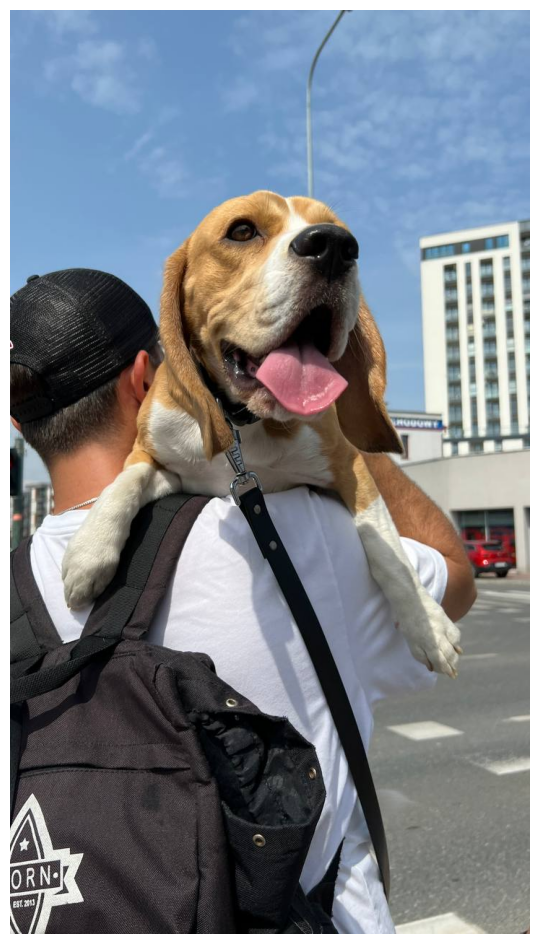

In [9]:
sv.plot_image(image)

Next, let's generate an image with Set of Mark annotations. We can do this using the `multimodal-maestro` `SegmentAnythingMarkGenerator` utility, which uses the Segment Anything model to segment objects and then adds Set of Mark annotations:

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
generator = mm.SegmentAnythingMarkGenerator(device=device)

config.json:   0%|          | 0.00/6.57k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.56G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

In [11]:
marks = generator.generate(image=image)

Now we have generated our marks, we can visualize them on an image:

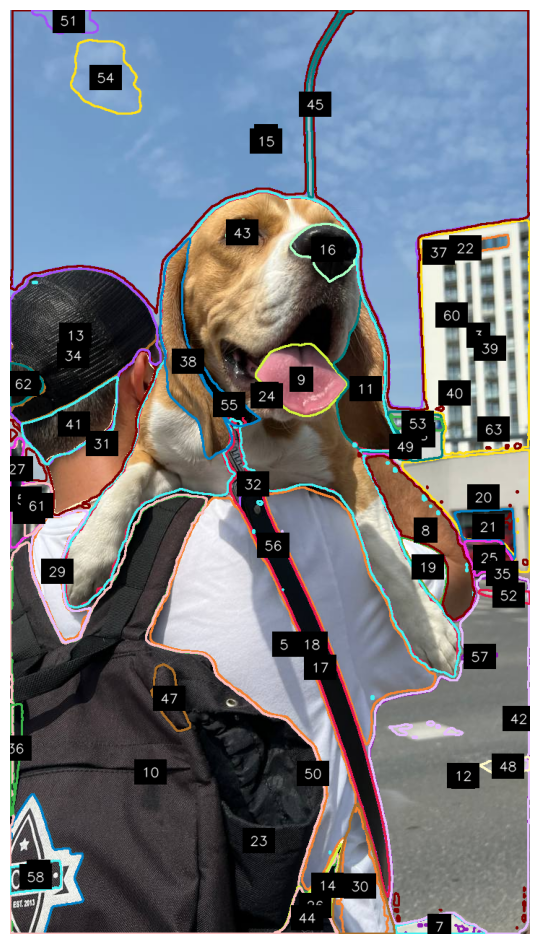

In [12]:
mark_visualizer = mm.MarkVisualizer()
marked_image = mark_visualizer.visualize(image=image, marks=marks)
sv.plot_image(marked_image)

The resulting image contains a lot of masks, including some masks which are small and not useful for this example. We can refine our masks by mask area, allowing us to consolidate some masks and generate larger masks that better represent the contents of the image:

In [14]:
refined_marks = mm.refine_marks(marks=marks, minimum_mask_area=0.04)

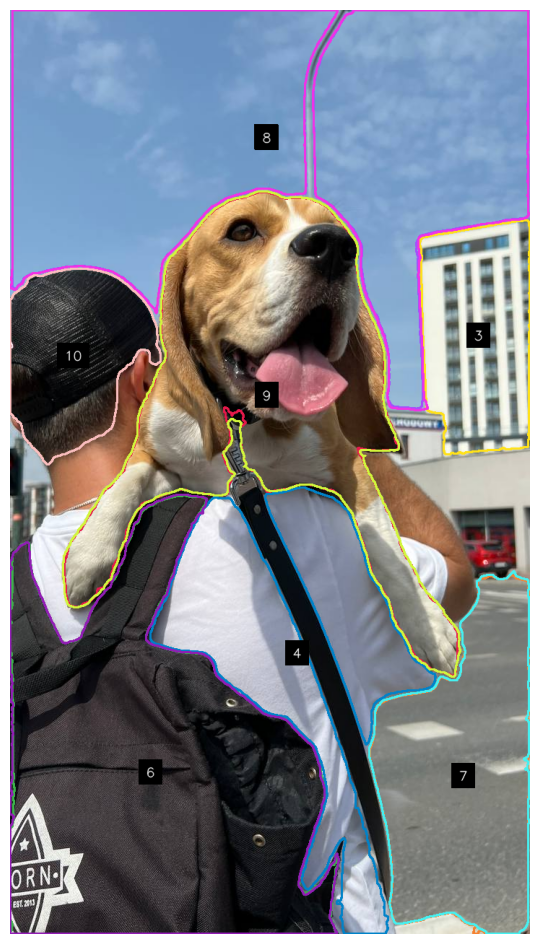

In [15]:
mark_visualizer = mm.MarkVisualizer()
marked_image = mark_visualizer.visualize(image=image, marks=refined_marks)
sv.plot_image(marked_image)

Now that we have our image annotated with Set of Mark annotations, we can send the image to GPT-4 with Vision. Let's  

In [22]:
api_key="..."

prompt="Find backpack. notalk;justgo"

In [23]:
response = mm.prompt_image(api_key=api_key, image=marked_image, prompt=prompt)
response

'The backpack is located in the lower left quadrant of the image, within the outlined area labeled with the number [6].'

**extract related marks**

In [24]:
masks = mm.extract_relevant_masks(text=response, detections=refined_marks)

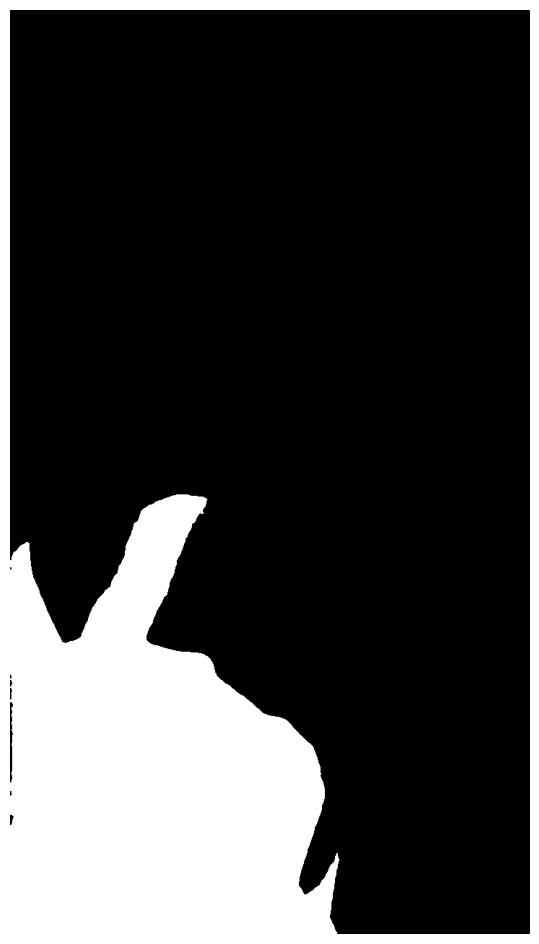

In [25]:
for mark in masks.values():
    sv.plot_image(mark)

## 🏆 Congratulations

### Learning Resources

Roboflow has produced many resources that you may find interesting as you advance your knowledge of computer vision:

- [Roboflow Notebooks](https://github.com/roboflow/notebooks): A repository of over 20 notebooks that walk through how to train custom models with a range of model types, from YOLOv7 to SegFormer.
- [Roboflow YouTube](https://www.youtube.com/c/Roboflow): Our library of videos featuring deep dives into the latest in computer vision, detailed tutorials that accompany our notebooks, and more.